<a href="https://colab.research.google.com/github/alirezaghavamipour/pplr_ss/blob/main/Copy_of_Copy_of_property_inference_attack_xiya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Possible Reason


0.   overfitting --> 10-cross-validation is already perfomed during training
1.   the size of meta-training set is relatively small --> **solution**: train more shadow models
2.   the structure of classifier --> **solution**: compare two classifier
3.   feature extraction --> **solution**: verify data and label
4.   shadow models --> **solution**: force test accuracy above 0.9
5.   training data --> **solution**: generate noisy training data/ mix it with original data
6.   the similarity between training data --> **solution**: random sample training data from MNIST dataset
7.   the shadow model is a linear model which is more easily to get similar trained model --> **solution**(***TODO***): visualize the meta-training set, PCA 
8.   too much parameters in baseline/neural sorting classifier --> **solution**(***TODO***): switch to other dataset to verify
9.   the author made use of pytorch while I use tensorflow



## Step 1  get training data for shadow model


In [ ]:
!pip install keras
!pip install kaggle

# download NIST dataset for training shadow model
!gdown --id 1w0EKrdoY01JuMDvH9wDD-ZUi23PZonrj
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

import os
if not os.path.exists("./Data"):
    os.mkdir("./Data")
os.chdir("./Data")
!kaggle datasets download -d sachinpatel21/az-handwritten-alphabets-in-csv-format
!unzip az-handwritten-alphabets-in-csv-format
os.chdir("/content/")

Downloading...
From: https://drive.google.com/uc?id=1w0EKrdoY01JuMDvH9wDD-ZUi23PZonrj
To: /content/kaggle.json
100% 64.0/64.0 [00:00<00:00, 134kB/s]
 94% 173M/185M [00:01<00:00, 132MB/s]
100% 185M/185M [00:01<00:00, 131MB/s]
Archive:  az-handwritten-alphabets-in-csv-format.zip
  inflating: A_Z Handwritten Data.csv  
  inflating: A_Z Handwritten Data/A_Z Handwritten Data.csv  


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
from pandas import read_csv
 
def load_mnist_data():
    mnist = tf.keras.datasets.mnist
    (train_data, train_label), (test_data, test_label)  = mnist.load_data()              #Load data from folder
    train_data, test_data = train_data.reshape(-1,28,28,1).astype('float32')/255.0, test_data.reshape(-1,28,28,1).astype('float32')/255.0
    train_label, test_label = to_categorical(train_label), to_categorical(test_label)
 
    return train_data, test_data, train_label, test_label
 
def load_shadow_data():
    data_path = "Data/handwritten_charactor.npz"
    if os.path.exists(data_path):
        with np.load(data_path) as f:
            train_data, test_data, train_label, test_label = f['train_data'], f['test_data'], f['train_label'], f['test_label']
    else:
        file_path = "Data/A_Z Handwritten Data.csv"
        data = read_csv(file_path)
        label = to_categorical(data['0'].values)
        data = data.drop(labels='0', axis='columns')
        data = data.values.reshape(-1, 28, 28,1).astype('float32')/255.0
 
        # random sample from data to create test data
        index = np.sort(np.random.choice(range(data.shape[0]), int(data.shape[0]*0.2), replace=False))
 
        test_data = data[index]
        train_data = np.delete(data, index, axis=0)
        test_label = label[index]
        train_label = np.delete(label, index, axis=0)
 
        with open(data_path, 'wb') as f:
            np.savez_compressed(f, train_data = train_data, test_data = test_data, train_label = train_label, test_label = test_label)
 
    return train_data, test_data, train_label, test_label  
 
def load_noisy_data(is_shadow, brightness_range=(0,10), train_data = None, test_data = None, train_label = None, test_label = None):
    if is_shadow:
        file_path = "./Data/shadow_noisy_{}_{}.npz".format(brightness_range[0], brightness_range[1])
    else:
        file_path = "./Data/mnist_noisy_{}_{}.npz".format(brightness_range[0], brightness_range[1])
    if os.path.exists(file_path):
        with np.load(file_path) as loaded:
            train_data_noisy = loaded['train_data_noisy']
            train_label_noisy = loaded['train_label_noisy']
            test_data_noisy = loaded['test_data_noisy']
            test_label_noisy = loaded['test_label_noisy']
    else:
        # create the noisy data generator
        datagen = ImageDataGenerator(
            brightness_range = brightness_range
        )
 
        train_data_noisy_generator = datagen.flow(train_data, train_label, batch_size=1, shuffle=False)
        test_data_noisy_generator = datagen.flow(test_data, test_label, batch_size=1, shuffle=False)
 
        train_data_noisy =  np.empty(train_data.shape)
        train_label_noisy =  np.empty(train_label.shape)
        test_data_noisy = np.empty(test_data.shape)
        test_label_noisy = np.empty(test_label.shape)
 
        # iterate though all train_data to geneate the noisy data
        for  i in range(len(train_data)):
            train_data_noisy[i], train_label_noisy[i] = next(train_data_noisy_generator)
 
        for  i in range(len(test_data)):
            test_data_noisy[i], test_label_noisy[i] = next(test_data_noisy_generator)
 
        train_data_noisy, test_data_noisy = train_data_noisy/255, test_data_noisy/255
 
        with open(file_path, 'wb') as f:
            np.savez_compressed(f, train_data_noisy = train_data_noisy, test_data_noisy = test_data_noisy, train_label_noisy = train_label_noisy, test_label_noisy = test_label_noisy)
 
    return train_data_noisy, test_data_noisy, train_label_noisy, test_label_noisy

## Step 2 create the shadow model 
Create the shadow model with three hidden fully connected layer with 128, 32, and 16 parameters.

In [ ]:
from pandas import  DataFrame
from keras import Sequential
from keras.layers import Input, Flatten, Dense
 
def get_model(output=10):
    model = Sequential(                      #define model structure
            [
                Input(shape=(28,28,1)),
                Flatten(),
                Dense(128, activation="relu"),
                Dense(32, activation="relu"),
                Dense(16, activation="relu"),
                Dense(output, activation="softmax")
            ]
        )
    return model

Funtion "save_model" for save parameters of shadow models

In [ ]:
def save_model(model, history, modelname):
    if not os.path.exists("./Models/"):
      os.mkdir("./Models/")
    FILENAME = "./Models/" + modelname                #Models are stored in a folder
    HISTNAME = FILENAME + '/history.csv'                  #The history file
    model.save(FILENAME)                                                #save the model
    print("Model saved at " + FILENAME)
    DataFrame.from_dict(history).to_csv(HISTNAME,index=False)

## Step 3 Training models
Function "train_model" for training a pair of shadow model based on original data and noisy data.

In [ ]:
def train_model(name):
    print("Start training model " + str(name))
    if is_shadow:
        model_original, model_noisy = get_model(26), get_model(26)
    else:
        model_original, model_noisy = get_model(), get_model()
    model_original.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model_noisy.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    # train a model based on original data
    test_accur = 0
    while test_accur < 0.9:
        sample_index = np.random.choice(range(0,len(train_image)), int(0.2*len(train_image)), replace=False)
        history_original = model_original.fit(train_image[sample_index], train_label[sample_index], epochs = 5, validation_split = 0.1)
        _, test_accur = model_original.evaluate(test_image, test_label)
    save_model(model_original, history_original.history, PREFIX_ORIGINAL + str(name))
 
    test_accur = 0
    while test_accur < 0.9:
        # train a model based on noisy data
        sample_index = np.random.choice(range(0,len(train_image_noisy)), int(0.2*len(train_image_noisy)), replace=False)
        history_noisy = model_noisy.fit(train_image_noisy[sample_index], train_label_noisy[sample_index], epochs = 5, validation_split = 0.1)
        _, test_accur = model_noisy.evaluate(test_image_noisy, test_label_noisy)
    save_model(model_noisy, history_noisy.history, PREFIX_NOISY + str(name))
 
    return None

Batch train models

In [ ]:
# Prepare data
 
dataset = "mnist"
is_shadow = int(input("Please supply model type(0: target model, 1: shadow model): "))
if  is_shadow:
    train_image, test_image, train_label, test_label = load_shadow_data()
else:
    train_image, test_image, train_label, test_label = load_mnist_data()
brightness_range = (0,5)
train_image_noisy, test_image_noisy, train_label_noisy, test_label_noisy = load_noisy_data(is_shadow,brightness_range, train_image, test_image, train_label, test_label)

Please supply model type(0: target model, 1: shadow model): 1


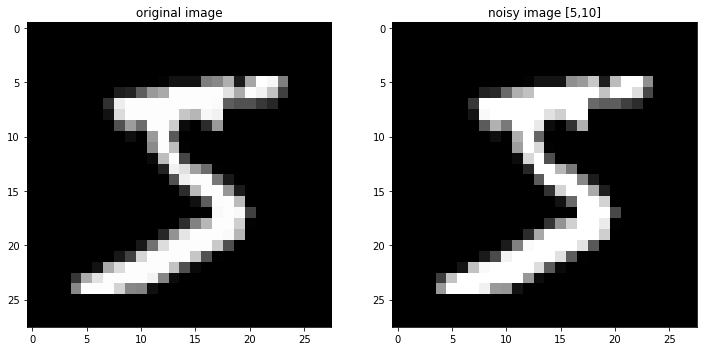

In [ ]:
def show_sample_noisy_image(train_image, train_image_noisy):
    fig = plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.title("original image")
    plt.imshow(train_image.reshape(28,28),cmap='gray')
    plt.subplot(1,2,2)
    plt.title("noisy image [5,10]")
    plt.imshow(train_image_noisy.reshape(28,28),cmap='gray')

# Show the comparison of original image and noisy data
show_sample_noisy_image(train_image[0], train_image_noisy[0])

In [ ]:
# train models
start_number = int(input("Supply the start number:"))
times = int(input("Supply the training times:"))
PREFIX = ['TARGET-', 'SHADOW-'][is_shadow]

PREFIX_ORIGINAL = PREFIX + "ORIGINAL-"
PREFIX_NOISY = PREFIX +  "NOISY-"
if times and PREFIX:
    for i in range(start_number, start_number + times):
      train_model(i)
else:
    print("Training stopped.")

Supply the start number:0
Supply the training times:20
Start training model 0
Epoch 1/5
1676/1676 [==============================] - 7s 4ms/step - loss: 0.7158 - accuracy: 0.8070 - val_loss: 0.3840 - val_accuracy: 0.8955
Epoch 2/5
1676/1676 [==============================] - 6s 4ms/step - loss: 0.2898 - accuracy: 0.9186 - val_loss: 0.2878 - val_accuracy: 0.9228
Epoch 3/5
1676/1676 [==============================] - 6s 3ms/step - loss: 0.2110 - accuracy: 0.9412 - val_loss: 0.2520 - val_accuracy: 0.9307
Epoch 4/5
1676/1676 [==============================] - 6s 3ms/step - loss: 0.1686 - accuracy: 0.9523 - val_loss: 0.2241 - val_accuracy: 0.9426
Epoch 5/5
2328/2328 [==============================] - 7s 3ms/step - loss: 0.1987 - accuracy: 0.9447
INFO:tensorflow:Assets written to: ./Models/SHADOW-ORIGINAL-0/assets
Model saved at ./Models/SHADOW-ORIGINAL-0
Epoch 1/5
1676/1676 [==============================] - 6s 3ms/step - loss: 0.8488 - accuracy: 0.7800 - val_loss: 0.4367 - val_accuracy: 0.

## Step 4 Feature extraction
In this section, we will extract features from saved models.

1.   Baseline approach: function ***load_variables_baseline***,  

  for each layer:
  * load weights from all nodes, 
  * flatten it to a 1d vector. 
2.   Neural sorting approach:  function ***load_variables_soritng***, 

  for each layer:
  * load weights from each node, 
  * calculate the sum of weights,
  * sort nodes by the value of sum. 

  concanenage the obtained node vectors from three layer and flatten it to a 1d vector.
3.   Deepset: *load_variables_deepset*: ***load_variables_deepset***, 

  for each layer:
 * load weights from each node, 
 * concananent each weight matrix with bias, 
 * flatten each matrix to a 1d vector as node representation.
 
 return an list consists of three arrays of node presentations from each layer.

The functions with suffix ***from_model***  are used for loading variables from a single model, while functions without the suffix are used for batch loading variables from a set of models.




In [ ]:
import numpy as np
from keras.models import load_model
from multiprocessing import Pool
from os import path
from pandas import DataFrame

from_shadow = True
PREFIX = 'TARGET-'
prefix_prop = 'NOISY-'
model_folder = './Models/'
approach = 0

def extract_features_from_model(index):
    prefix = [PREFIX + "ORIGINAL-", PREFIX + prefix_prop]
    vectors = []
    labels = []
    for p in prefix:
        vector = []
        model_path = model_folder + p + str(index)
        if path.exists(model_path):
            model = load_model(model_path)
            # ignore the flatten layer and the output layer
            for layer in model.layers[1:-1]:
                if approach == 0:
                    weight = layer.weights[0].numpy().flatten()
                    weight = np.concatenate((weight, layer.weights[1].numpy().flatten()))
                    vector = weight if len(vector) == 0 else np.concatenate((vector, weight))
                elif approach == 1:
                    weight_sum = np.sum(layer.trainable_weights[0].numpy().T, axis=1)
                    weight_sum = np.argsort(weight_sum)                    
                    weight = np.column_stack((layer.trainable_weights[0].numpy().T, layer.trainable_weights[1].numpy().T))
                    weight = weight[weight_sum]
                    vector = weight.flatten() if len(vector) ==0 else np.concatenate((vector, weight.flatten()))
                elif approach == 2:
                    weights = layer.weights
                    vector.append(np.column_stack((weights[0].numpy().T, weights[1].numpy())))
            vectors.append(vector)
            labels.append([0,1] if p.find('NOISY') > 0 else [1,0])
        else:
            print("The requested model {} was not available!".format(p + str(index)))
    return [vectors, labels]

def extract_features_deepset(processes=2, n_models=80, appr = 2, from_shadowmodel = True):
    end = int(n_models/2)
    global from_shadow
    from_shadow = from_shadowmodel
    global approach
    approach = 2
    if processes > 1:
        with Pool(processes=processes) as pool:
            train_dataset = pool.map(extract_features_from_model, range(0, end))
    else:
        train_dataset = []
        for i in range(0, end):
            train_dataset.append(extract_features_from_model(i))

    print("Data loaded.")

    train_data_layer_1 = []
    train_data_layer_2 = []
    train_data_layer_3 = np.zeros(shape = (n_models,16,33))
    train_label = []

    # reconstruct the structure of weights
    for key, t in enumerate(train_dataset):
        for index, model in enumerate(t[0]):
            train_data_layer_1.append(model[0])
            train_data_layer_2.append(model[1])
            train_data_layer_3[2*key+index] = np.asarray(model[2])
        train_label.append(t[1])

    train_data_layer_1, train_data_layer_2, train_data_layer_3 = np.asarray(train_data_layer_1), np.asarray(train_data_layer_2), np.asarray(train_data_layer_3)
    train_label = np.asarray(train_label).reshape(n_models, 2)

    return [train_data_layer_1, train_data_layer_2, train_data_layer_3], train_label

def extract_features_vector(processes=1, n_models=80, appr = 0, from_shadowmodel = True):
    end = int(n_models/2)
    global from_shadow
    from_shadow = from_shadowmodel
    if from_shadow:
        global PREFIX
        PREFIX = 'SHADOW-'
    global approach
    approach = appr
    if processes > 1:
        with Pool(processes=processes) as pool:
            train_dataset = pool.map(extract_features_from_model, range(0, end))
    else:
        train_dataset = []
        for i in range(0, end):
            train_dataset.append(extract_features_from_model(i))

    print("Data loaded.")

    train_data = []
    train_label = []
    for train_models in train_dataset:
        train_data.append(train_models[0])
        train_label.append(train_models[1])

    train_data = np.asarray(train_data)
    train_label = np.asarray(train_label)
    train_data, train_label = train_data.reshape(-1, train_data.shape[-1]), train_label.reshape(n_models, 2)

    return train_data, train_label

## Step 5 Create the meta classifier



*   Baseline/Neural Sorting approach: input the feature vector, followed by three fully connected layer.
*   Deepset approach: input weights from three layers, each layer was processed individually.





In [ ]:
from keras.constraints import maxnorm
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Lambda, LocallyConnected1D, RepeatVector, Dropout
from keras.backend import concatenate
from tensorflow import reduce_sum

def create_meta_classifier_vector():
    input_layer = Input(shape=(105136,))
    x = Dropout(0.3)(input_layer)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(2, activation="softmax")(x)
    model = Model(inputs=input_layer, outputs=x)

    return model


def create_meta_classifier_deepset():
    input_1 = Input(shape=(128,785))
    x = LocallyConnected1D(3, 1, input_shape=(128,785), activation="relu")(input_1)
    # x new output shape (128, 3)
    output_1 = LocallyConnected1D(1, 1, activation="relu")(x)
    # x output shape (128,1) which is the vector consists of 128 node representations
    

    input_2 = Input(shape=(32,129))
    # Flattening the output from previous layer, 
    x = Flatten()(output_1)
    # duplicate it 
    x = RepeatVector(32)(x)
    #  concatenate each of flattend layer ve with node from current layer
    x = concatenate([input_2, x])
    x = LocallyConnected1D(3, 1, input_shape=(32,257), activation="relu")(x)
    output_2 = LocallyConnected1D(1, 1, activation="relu")(x)

    input_3 = Input(shape=(16,33))
    x = Flatten()(output_2)
    x = RepeatVector(16)(x)
    x = concatenate([input_3, x])
    x = LocallyConnected1D(3, 1, input_shape=(16,65), activation="relu")(x)
    output_3 = LocallyConnected1D(1, 1, activation="relu")(x)

    x = concatenate([reduce_sum(output_1, axis=-1), reduce_sum(output_2, axis=-1), reduce_sum(output_3, axis=-1)])
    x = Dense(4, activation="relu")(x)
    x = Dense(2, activation="softmax")(x)

    classifier = Model(inputs = [input_1, input_2, input_3], outputs = x)

    return classifier

# Step 6 Save and Load feature representation

In [ ]:
from numpy import savez_compressed, load

def save_data(approach_name, n_train, n_test, train_data, test_data, train_label, test_label):
    path = './Data/'
    with open(path + approach_name + '{}shadow_{}target.npz'.format(n_train, n_test), 'wb') as f:
        if not approach_name == 'deepset':
            savez_compressed(f, train_data = train_data, train_label = train_label, test_data = test_data, test_label = test_label)
        else:
            savez_compressed(
                f, 
                train_data_0 = train_data[0].copy(),
                train_data_1 = train_data[1].copy(),
                train_data_2 = train_data[2].copy(),
                train_data_3 =  train_data[3].copy(),
                train_label = train_label, 
                test_data_0 = test_data[0].copy(), 
                test_data_1 = test_data[1].copy(),
                test_data_2 = test_data[2].copy(),
                test_data_3 = test_data[3].copy(),
                test_label = test_label)

def load_data(approach_name, n_train, n_test):
    path = './Data/'
    try:
        with load(path + approach_name + '{}shadow_{}target.npz'.format(n_train, n_test)) as loaded:
            if not approach_name == 'deepset':
                train_data = loaded['train_data']
                train_label = loaded['train_label']
                test_data = loaded['test_data']
                test_label = loaded['test_label']
            else:
                train_data = [loaded['train_data_0'], loaded['train_data_1'], loaded['train_data_2'], loaded['train_data_2']]
                train_label = loaded['train_label']
                test_data = [loaded['test_data_0'], loaded['test_data_1'], loaded['test_data_2'], loaded['test_data_2']]
                test_label = loaded['test_label']
            return train_data, test_data, train_label, test_label
    except:
        print("The data file does not exist!")
    return
    

# Step 7 Train the meta classifier

In [ ]:
from keras import optimizers

file_name = input("Supply filename or press enter to create a new classifier:")
approach = int(input("Select the approach(0,baseline 1,sorting 2,deepset):"))
approach_name = ['baseline', 'neural sorting', 'deepset']

load_variable = [extract_features_vector, extract_features_vector, extract_features_deepset]
create_classifier = [create_meta_classifier_vector, create_meta_classifier_vector, create_meta_classifier_deepset]

# Finished: save and load variables 
n_train = int(input("Supply the number of shadow models:"))
n_test = int(input("Supply the number of target models:"))
reload_data = input("Do you want to reload data?(y/n):")
if reload_data == 'y':
    n_p = 1
    train_data, train_label = load_variable[approach](n_p, n_train, approach)
    test_data, test_label = load_variable[approach](n_p, n_test,approach, from_shadowmodel = False)
    save_data(approach_name[approach], n_train, n_test, train_data, test_data, train_label, test_label)
else:
    train_data, test_data, train_label, test_label = load_data(approach_name[approach], n_train, n_test)
    # test_data, train_data, test_label, train_label = io_variables.load_data(approach_name[approach], n_train, n_test)

print("Start training......")
if file_name:
    classifier, history = load_old_model(file_name)
else:
    classifier = create_classifier[approach]()
    classifier.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    if approach == 2:
        history = classifier.fit([train_data[0], train_data[1], train_data[2]], train_label, validation_split = 0.1, epochs=10)
    else:
        history = classifier.fit(train_data, train_label, validation_split = 0.1, epochs = 10)
    history = history.history

classifier.summary()
# plot_accuracy(history)
if approach == 2:
    test_loss, test_accur = classifier.evaluate([test_data[0], test_data[1], test_data[2]], test_label)
    print("Current approach is {}, tested on {} models, test accuracy is {}.".format(approach_name[approach], len(test_data[0]), test_accur))
    prediction = classifier.predict([test_data[0], test_data[1], test_data[2]])
else:
    test_loss, test_accur = classifier.evaluate(test_data, test_label)
    print("Current approach is {}, tested on {} models, test accuracy is {}.".format(approach_name[approach], len(test_data), test_accur))
    prediction = classifier.predict(test_data)

# plot_confusion_matrix(test_label, prediction)
if not file_name:
    file_name = input("Supply the name if you want to save the claasifier:")
    if file_name:
        save_model(classifier, history, file_name)
    else:
        print("Classifier is not saved.")

Supply filename or press enter to create a new classifier:
Select the approach(0,baseline 1,sorting 2,deepset):0
Supply the number of shadow models:10
Supply the number of target models:2
Do you want to reload data?(y/n):y
Data loaded.
Data loaded.
Start training......
Epoch 1/10
1/1 [==============================] - 1s 864ms/step - loss: 0.6988 - accuracy: 0.5556 - val_loss: 0.5460 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 86ms/step - loss: 0.1094 - accuracy: 1.0000 - val_loss: 0.4106 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 91ms/step - loss: 0.0450 - accuracy: 1.0000 - val_loss: 0.2751 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 87ms/step - loss: 3.9736e-08 - accuracy: 1.0000 - val_loss: 0.1958 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 81ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.1446 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==========